In [1]:
import desitarget 
from desitarget.targets import desi_mask, bgs_mask, mws_mask

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_clustering.dat.fits')
N['APPLIM'] = 19.539993
S['APPLIM'] = 19.5
N['ZLIM_UPPER'] = 0.6
S['ZLIM_UPPER'] = 0.6

In [3]:
data = Table(np.hstack((N, S)))

data

TARGETID,Z,NTILE,TILES,RA,DEC,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NZ,WEIGHT_FKP,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP1,ABSMAG_RP0,APPLIM,ZLIM_UPPER
int64,float64,int64,bytes11,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633366047264297,0.16095951646742163,1,20001,268.7008850398322,58.31651750837625,2.368794267525197,1.0202607,2.0,1.1608769635685512,7.7169294,16.809292,28.698618,21.945616,12.552565,0.01856145426373512,0.016762400045732102,0.721548822097457,-0.0480892836645471,0.07562442170381622,0.17676402087349832,0.38471493423821956,0.637311614101099,-0.15613073097339897,-0.15613073097339897,-19.01505339080518,-19.239906695343226,19.539993,0.6
39633366047264412,0.2262081883049673,1,20001,268.7121644210125,58.17137871856034,7.885935437241774,1.0119702,7.0,1.1132365826456456,5.6451545,17.743734,36.715954,42.338474,30.138641,0.008661962234134126,0.03524444880947024,0.8916872718248806,0.055141909042679765,0.4068761917832286,0.28235492619244257,0.7782674152354703,0.7475090655224019,-0.21942194265581827,-0.21942194265581827,-19.934640009395764,-20.16185302654553,19.539993,0.6
39633366047264710,0.20509598282456507,1,20001,268.7447179685751,58.35164090788789,3.5493453409436366,1.0191563,3.0,1.1608769635685512,9.199382,18.115196,31.323214,38.144897,31.80481,0.011911149469520776,0.025879084952906813,0.5397214238839109,-0.06256931584764004,0.13341940431141774,0.14342391928728798,0.37673369579311694,0.5024003675371398,-0.19894310333982812,-0.19894310333982812,-19.621429255164735,-19.82742249029966,19.539993,0.6
39633378638561503,0.3053206447975358,1,20001,270.5073482253405,59.33896919077583,2.3158908743540527,1.0118785,2.0,1.1443522597899662,5.816003,24.00663,49.666294,60.648766,39.263374,0.0032132398416806277,0.08965087986982612,0.948196974030458,0.1920467162085221,0.783116328481775,0.4201382412002311,1.1720507422145277,0.7873540852894143,-0.2961610254536097,-0.2961610254536097,-21.06440409622748,-21.29249562121919,19.539993,0.6
39633372376467396,0.2775320962351793,1,20001,268.5121713053863,58.81550252397294,3.2715555825991145,1.0216688,3.0,1.067389487000734,4.9087415,18.647816,47.224636,121.78173,128.69661,0.006279602345083299,0.047974048180681544,0.9314978452803849,0.14147467853484277,0.6591231040064112,0.36796505192895507,1.0449898286507322,0.7721214940301759,-0.26920613334812393,-0.26920613334812393,-20.528724008118733,-20.755214381512847,19.539993,0.6
39633366047264487,0.10750217420934505,1,20001,268.72025843577376,58.150995263304566,3.3792646040688217,1.0118438,3.0,1.1132365826456456,65.581665,164.53503,310.0892,251.75818,156.65999,0.026715267796619462,0.011706208574030397,0.9793147837596916,-0.09317160654032018,-0.07379673881075391,0.1383131834916128,0.320207896877415,0.8167949381034556,-0.10427710898306469,-0.10427710898306469,-20.549183985528458,-20.78066877556039,19.539993,0.6
39633366047264069,0.23373774756268273,1,20001,268.6773406567538,58.196956322063585,5.65722136226266,1.0163556,5.0,1.1132365826456456,5.1988206,18.016794,36.307766,35.975773,23.484913,0.008661962234134126,0.03524444880947024,0.9539436956606155,0.08093321342091594,0.4764215093374489,0.30965139400867076,0.8662922728465651,0.7927911127392542,-0.22672561513580225,-0.22672561513580225,-20.049808198242104,-20.27852637882986,19.539993,0.6
39633366051455429,0.2274295421540546,1,20001,268.86868202000977,58.30892044280674,2.274872090138421,1.0217379,2.0,1.1132365826456456,24.459436,80.40709,158.21242,162.85123,116.77073,0.008661962234134126,0.03524444880947024,0.922871669122532,0.06516651677486968,0.43441482751073607,0.2918134730009922,0.8171449928840472,0.7667884599753434,-0.22060665588943296,-0.22060665588943296,-21.597261119229156,-21.82390807545528,19.539993,0.6
39633366

In [6]:
redshift_cut = np.where(data['Z'] <= 0.6)[0]
def zmax(m):
    return 10**(-(m+22.8)/5)

M_range = np.arange(-23,-12,0.1)
zmax_range = np.clip(zmax(M_range),a_min=None,a_max=0.6)

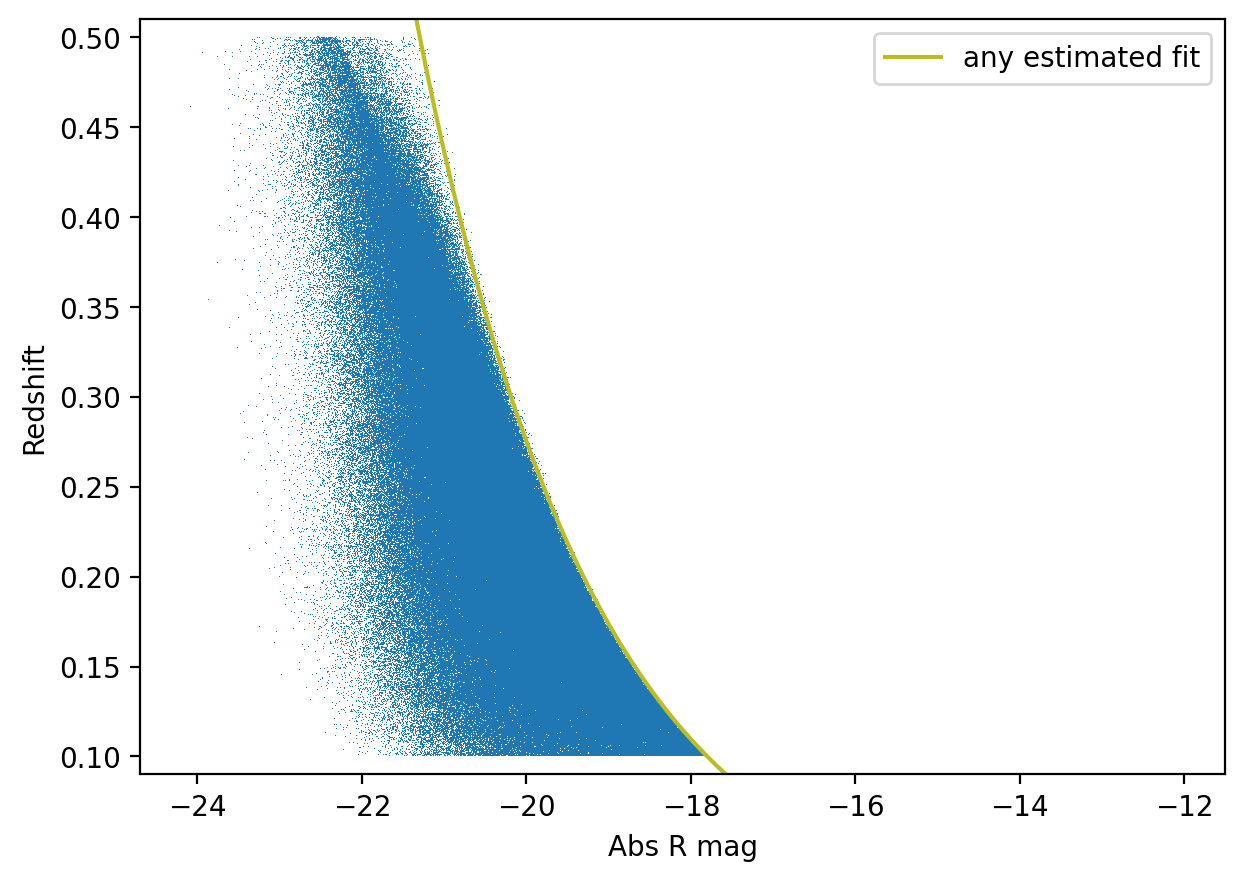

In [7]:
fig, ax1 = plt.subplots(figsize=(7,5),dpi=200)
ax1.plot(data['ABSMAG_RP1'][redshift_cut], data['Z'][redshift_cut], lw=0, marker=',')
#¢ax1.set_yscale('log')
ax1.plot(M_range, zmax_range, label='any estimated fit', color='tab:olive')
#ax1.scatter(data['ABSMAG_RP1P1'], zmax_clipped, color='tab:red', s=0.01)
plt.ylabel('Redshift')
plt.xlabel('Abs R mag')
plt.legend()
plt.ylim(0.09,0.51)
plt.show()

In [11]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)
data['DL'] = cosmo.luminosity_distance(np.array(data['Z']))

In [12]:
data['ABSMAG_LIM'] = data['APPLIM'] - 5*np.log10(data['DL'])-25-data['KCORR_R0P1']-data['EQ_ALL_0P1']

In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

195603 0.14999975607170113
514764 0.4700007198589736
368346 0.3230006227475963


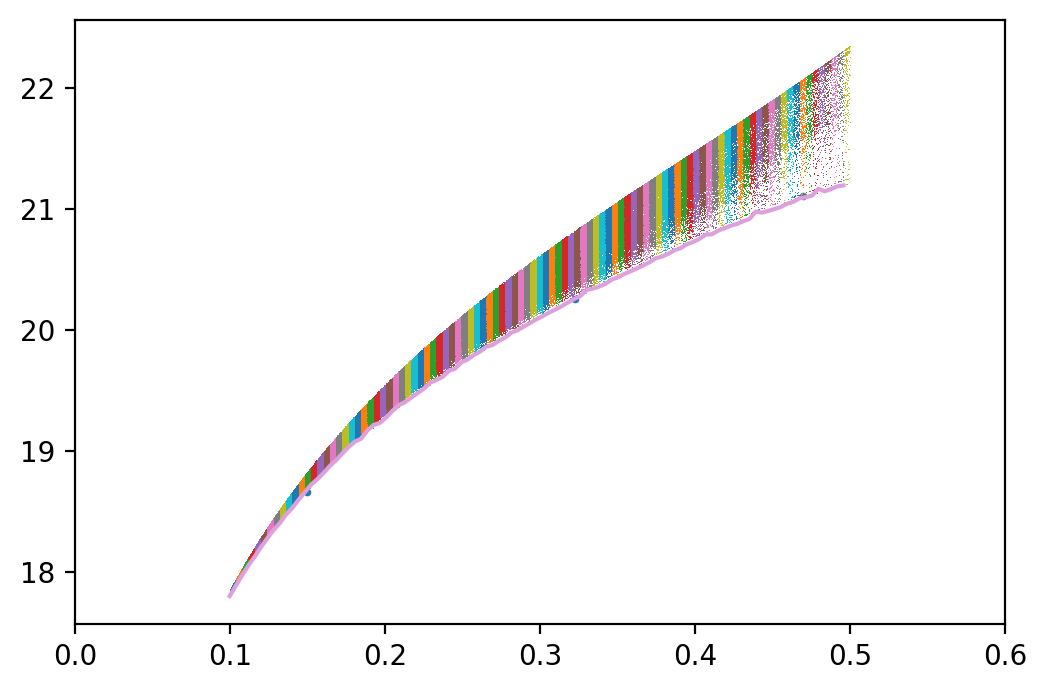

In [14]:
plt.figure(dpi=200)
def find_absmag_envelope(z_range): #obsolete
    if isinstance(z_range, np.ndarray):
        a = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(data['Z'] > (z), data['Z'] < (z_range[i+1])))[0]

            #plt.plot([zmid,zmid], [17,22])
            plt.plot(data['Z'][z_close], -data['ABSMAG_LIM'][z_close], lw=0, marker=',', label='absmaglim')

            try:
                absmag_min = np.amax(np.array(data['ABSMAG_LIM'][z_close]))
            except:
                absmag_min = np.nan
            a[i] = absmag_min
            #plt.scatter(z, -absmag_min, s=10)
        return a
    elif isinstance(z_range, float):
        z = z_range
        z_closest = find_nearest(data['Z'], z)
        print(z_closest, data['Z'][z_closest])
        z_close = np.where(np.logical_and(data['Z'] > (z-0.001), data['Z'] < (z+0.001)))[0]
        try:
            absmag_min = np.amax(np.array(data['ABSMAG_LIM'][z_close]))
        except:
            absmag_min = np.nan
        return absmag_min

z_range = np.linspace(0.1,0.5,100)        
absmag_env = find_absmag_envelope(z_range) 
plt.plot(z_range[0:-1], -absmag_env, color='plum')
plt.scatter(np.array((0.15,0.47,0.323)),-np.array((find_absmag_envelope(0.15),find_absmag_envelope(0.47),find_absmag_envelope(0.323))), s=3)
plt.xlim(0,0.6)
plt.show()

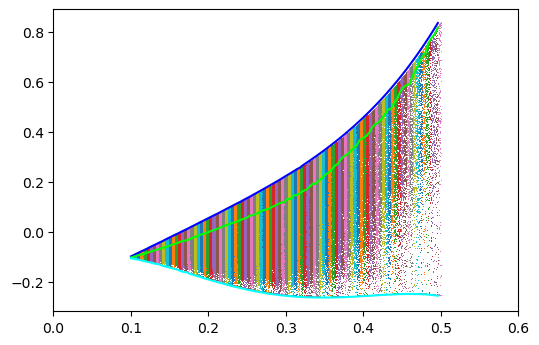

In [67]:
plt.figure(dpi=100)
def find_k(z_range, stat, cat):
    if isinstance(z_range, np.ndarray):
        k = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(cat['Z'] > (z), cat['Z'] < (z_range[i+1])))[0]
            plt.plot(cat['Z'][z_close], cat['KCORR_R0P1'][z_close], lw=0, marker=',')
            if stat == 'med':
                k[i] = np.median(cat['KCORR_R0P1'][z_close])
            elif stat == 'max':
                k[i] = np.amax(cat['KCORR_R0P1'][z_close])
            elif stat == 'min':
                k[i] = np.amin(cat['KCORR_R0P1'][z_close])
        return k


z_range = np.linspace(0.1,0.5,100)        
k_med = find_k(z_range, 'med', data) 
k_max = find_k(z_range, 'max', data)
k_min = find_k(z_range, 'min', data)
plt.plot(z_range[0:-1], k_max, color='blue')
plt.plot(z_range[0:-1], k_med, color='lime')
plt.plot(z_range[0:-1], k_min, color='aqua')

plt.xlim(0,0.6)
plt.show()

In [16]:
z1 = find_nearest(data['Z'], 0.2)
z2 = find_nearest(data['Z'], 0.4)
e_slope = (data['EQ_ALL_0P1'][z2] - data['EQ_ALL_0P1'][z1])/(data['Z'][z2] - data['Z'][z1])
print(data['Z'][z2], data['EQ_ALL_0P1'][z2])
print(data['Z'][z1], data['EQ_ALL_0P1'][z1])
print(e_slope)

e_intercept = data['EQ_ALL_0P1'][z2] - e_slope*data['Z'][z2]
print(e_intercept)
#y = mx+c

0.4000004507649722 -0.38800043724202304
0.1999998905457913 -0.19399989382941754
-0.9700000000000001
0.0


In [17]:
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z = e_slope*z_range[0:-1] + e_intercept
faintlim_range_N_max = 19.539993 - 5*np.log10(dl_range) - 25 - k_max - e_z
faintlim_range_S_max = 19.5  - 5*np.log10(dl_range) - 25 - k_max - e_z

faintlim_range_N_min = 19.539993 - 5*np.log10(dl_range) - 25 - k_min - e_z
faintlim_range_S_min = 19.5  - 5*np.log10(dl_range) - 25 - k_min - e_z

faintlim_range_N_med = 19.539993 - 5*np.log10(dl_range) - 25 - k_med - e_z
faintlim_range_S_med = 19.5  - 5*np.log10(dl_range) - 25 - k_med - e_z

brightlim_range_max = 15 - 5*np.log10(dl_range) - 25 - k_max - e_z
brightlim_range_min = 15 - 5*np.log10(dl_range) - 25 - k_min - e_z
brightlim_range_med = 15 - 5*np.log10(dl_range) - 25 - k_med - e_z

In [74]:
def absmag_lim(lim0, lim1, cat):
    return np.where(np.logical_and(cat['ABSMAG_RP1'] < lim0, cat['ABSMAG_RP1'] > lim1))

def redshift_lim(lim, cat):
    return np.where(cat['Z'] < np.minimum(zmax(lim),0.6))

def redshift_lim_bright(lim, cat):
    return np.where(cat['Z'] < np.minimum(zmax_bright(lim),0.6))

def redshift_lim_from_k(lim0, lim1, cat):
    N_i = np.where(cat['APPLIM'] == 19.539993)
    S_i = np.where(cat['APPLIM'] == 19.5)
    cat['ZLIM_UPPER'][S_i] = z_range[find_nearest(faintlim_range_S_max,lim0)]
    cat['ZLIM_UPPER'][N_i] = z_range[find_nearest(faintlim_range_N_max,lim0)]

    upper_limed = np.where(cat['Z'] < np.minimum(cat['ZLIM_UPPER'],0.6))
    z_lim_lower = z_range[find_nearest(brightlim_range_min,lim1)]
    return np.intersect1d(upper_limed, np.where(cat['Z'] > z_lim_lower))

def find_zmax(M, lim_range):
    z_array = []
    for m in M:
        i = find_nearest(lim_range, m) #ignore faintlim differences between S and N (use 19.5)
        z_array.append(z_range[i])
    return z_array
    
M_range = np.arange(-23,-16,0.01)
print(redshift_lim_from_k(-20, -21,data))

data['ZMAX'] = find_zmax(data['ABSMAG_RP1'],faintlim_range_S_min)

[     0      1      2 ... 599196 599197 599198]


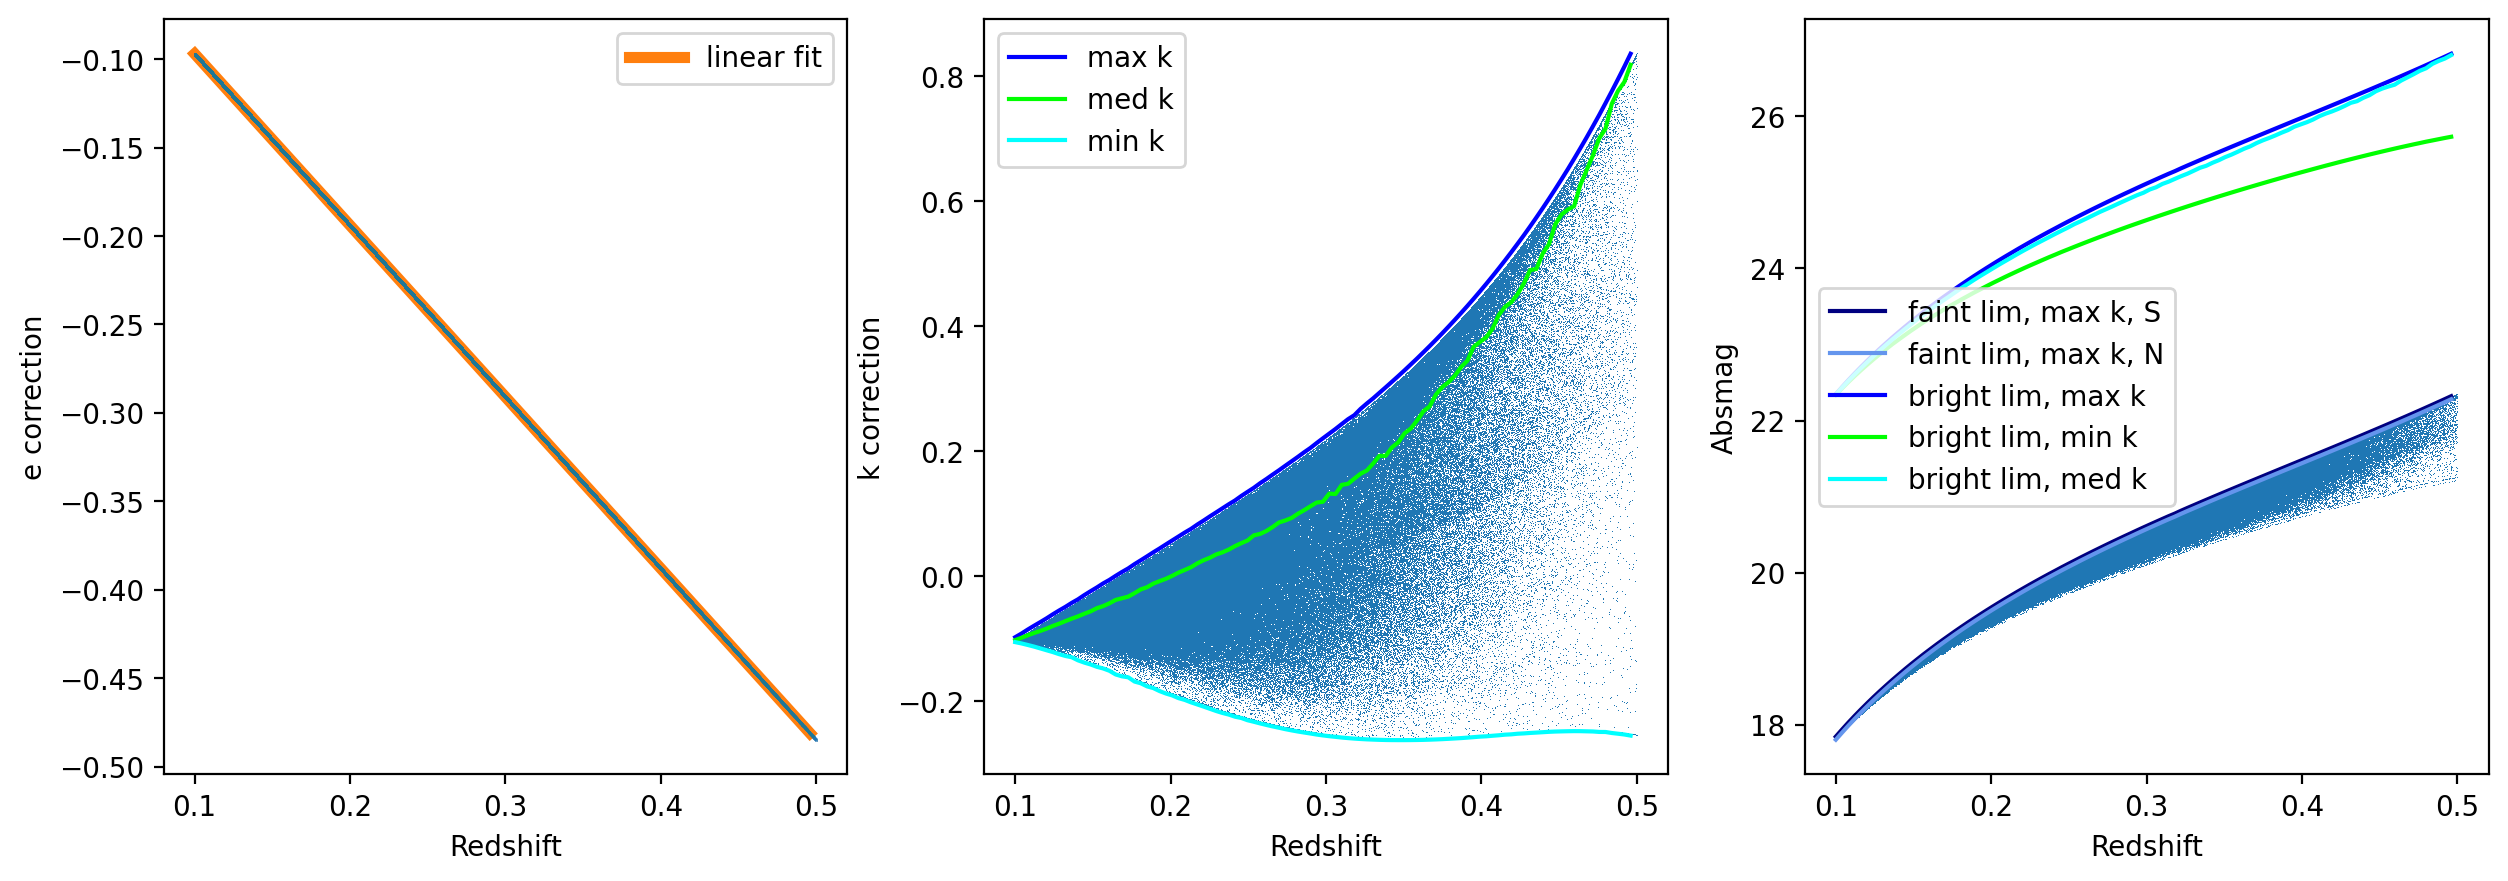

In [19]:
plt.figure(figsize=(15,5), dpi=200)

plt.subplot(131)
plt.plot(z_range[0:-1], e_z, label='linear fit', color='tab:orange', lw=4)
plt.plot(data['Z'], data['EQ_ALL_0P1'], lw=0, marker='o', color='tab:blue', markersize=0.01)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('e correction')

plt.subplot(132)
plt.plot(data['Z'], data['KCORR_R0P1'], lw=0, marker=',')
plt.plot(z_range[0:-1], k_max, color='blue', label='max k')
plt.plot(z_range[0:-1], k_med, color='lime', label='med k')
plt.plot(z_range[0:-1], k_min, color='aqua', label='min k')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('k correction')

plt.subplot(133)
plt.plot(data['Z'], -data['ABSMAG_LIM'], lw=0, marker=',')
plt.plot(z_range[0:-1], -faintlim_range_S_max, color='navy', label='faint lim, max k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_med, color='palegreen', label='med k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_min, color='darkturquoise', label='min k, N')
plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
plt.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Absmag')
plt.savefig('../figures/week8-9/da02_corrections_and_absmag.png')


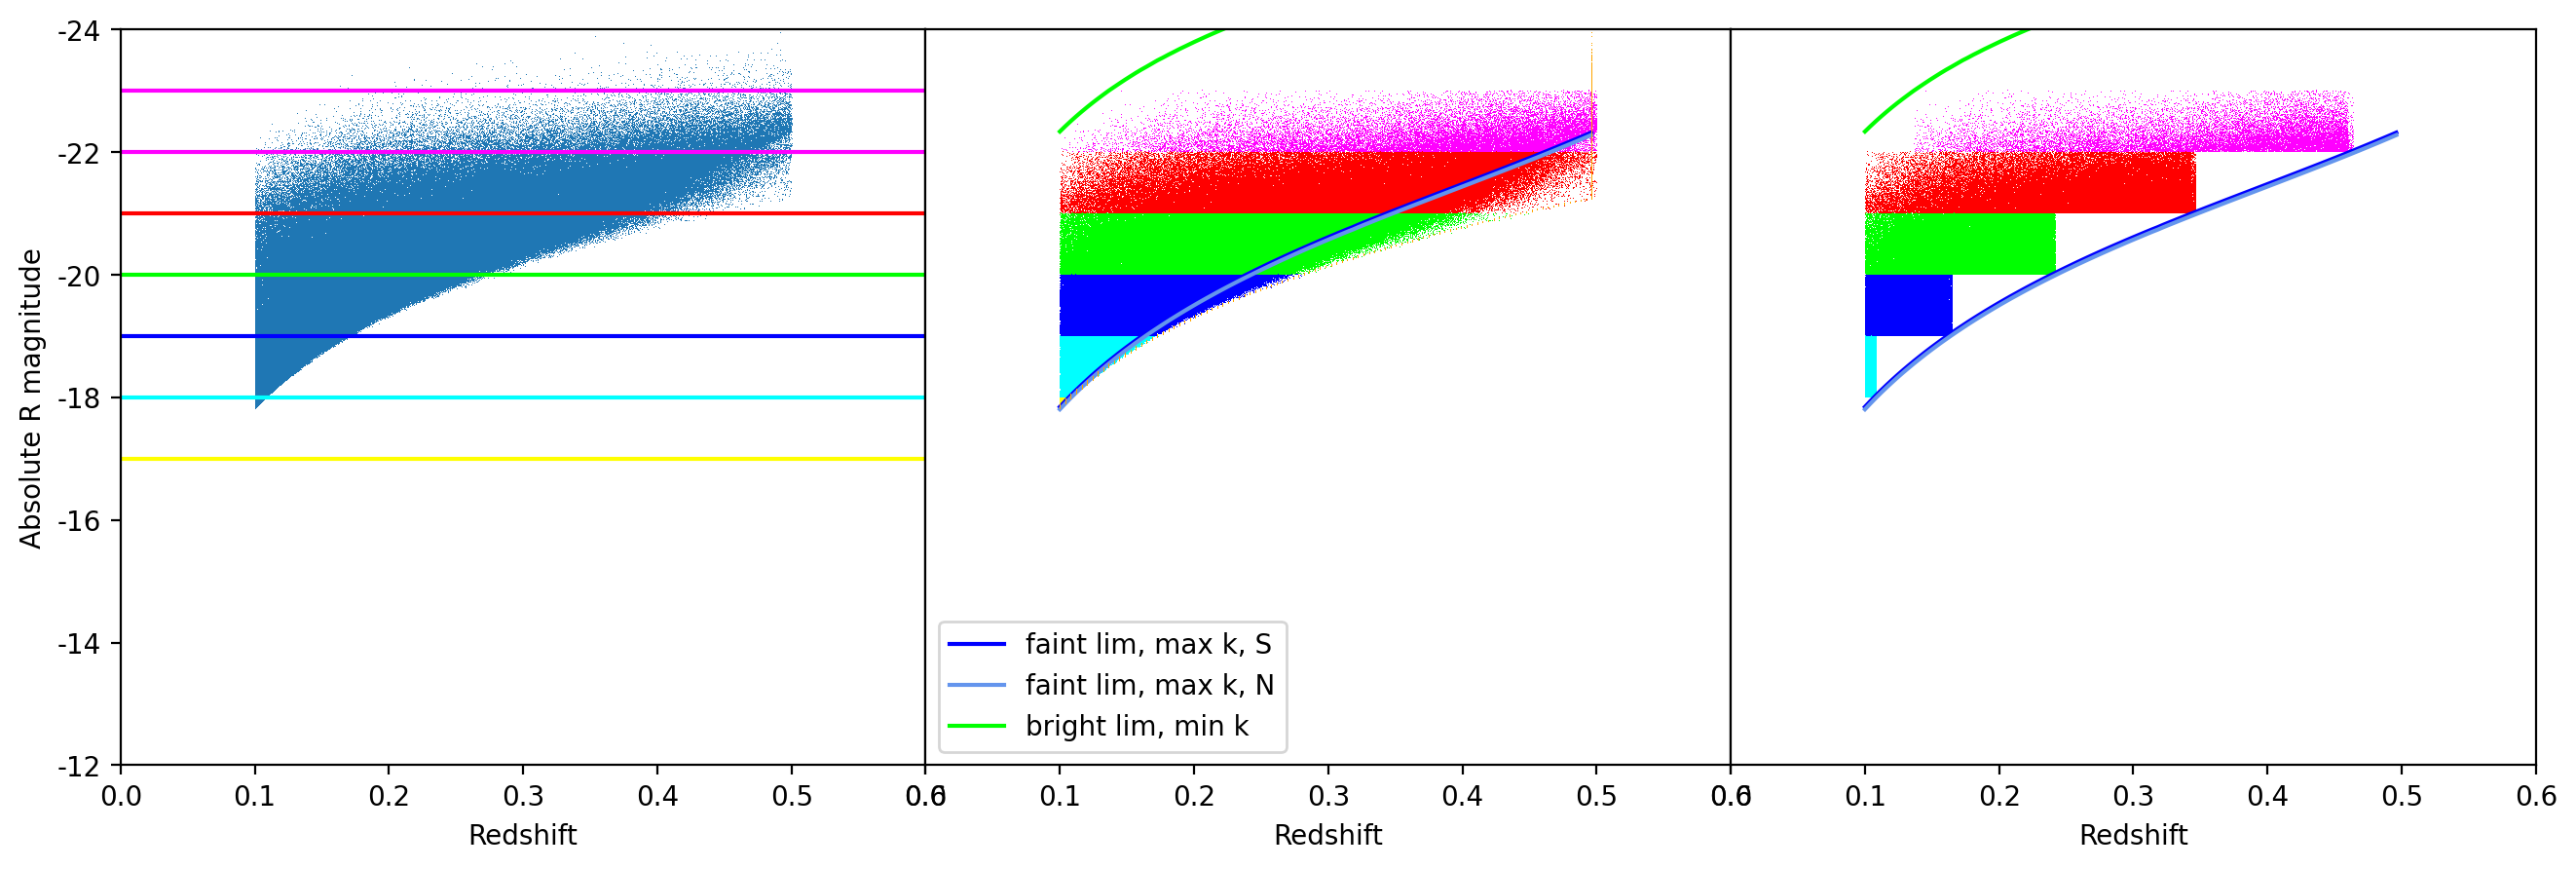

In [30]:
plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot(131)
ax1.plot(data['Z'], -data['ABSMAG_RP1'], lw=0, marker=',')
ax1.plot([0,0.6],[17,17], color='yellow')
ax1.plot([0,0.6],[18,18], color='cyan')
ax1.plot([0,0.6],[19,19], color='blue')
ax1.plot([0,0.6],[20,20], color='lime')
ax1.plot([0,0.6],[21,21], color='red')
ax1.plot([0,0.6],[22,22], color='magenta')
ax1.plot([0,0.6],[23,23], color='magenta')
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax2 = plt.subplot(132)
ax2.plot(data['Z'][absmag_lim(-17,-18, data)], -data['ABSMAG_RP1'][absmag_lim(-17,-18, data)], lw=0, marker=',', color='yellow')
ax2.plot(data['Z'][absmag_lim(-18,-19, data)], -data['ABSMAG_RP1'][absmag_lim(-18,-19, data)], lw=0, marker=',', color='cyan')
ax2.plot(data['Z'][absmag_lim(-19,-20, data)], -data['ABSMAG_RP1'][absmag_lim(-19,-20, data)], lw=0, marker=',', color='blue')
ax2.plot(data['Z'][absmag_lim(-20,-21, data)], -data['ABSMAG_RP1'][absmag_lim(-20,-21, data)], lw=0, marker=',', color='lime')
ax2.plot(data['Z'][absmag_lim(-21,-22, data)], -data['ABSMAG_RP1'][absmag_lim(-21,-22, data)], lw=0, marker=',', color='red')
ax2.plot(data['Z'][absmag_lim(-22,-23, data)], -data['ABSMAG_RP1'][absmag_lim(-22,-23, data)], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range, -M_range, color='tab:blue', lw=1, label='my estimate')
ax2.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')

#plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
#plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

ax2.plot(data['ZMAX'], -data['ABSMAG_RP1'], lw=0, marker=',', color='orange')

plt.legend()
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')

ax3 = plt.subplot(133)
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17,-18, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17,-18, data))], lw=0, marker=',', color='yellow')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18,-19, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18,-19, data))], lw=0, marker=',', color='cyan')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19,-20, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19,-20, data))], lw=0, marker=',', color='blue')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20,-21, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20,-21, data))], lw=0, marker=',', color='lime')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21,-22, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21,-22, data))], lw=0, marker=',', color='red')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22,-23, data))], -data['ABSMAG_RP1'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22,-23, data))], lw=0, marker=',', color='magenta')
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8-9/DA02_mag_v_redshift.png')


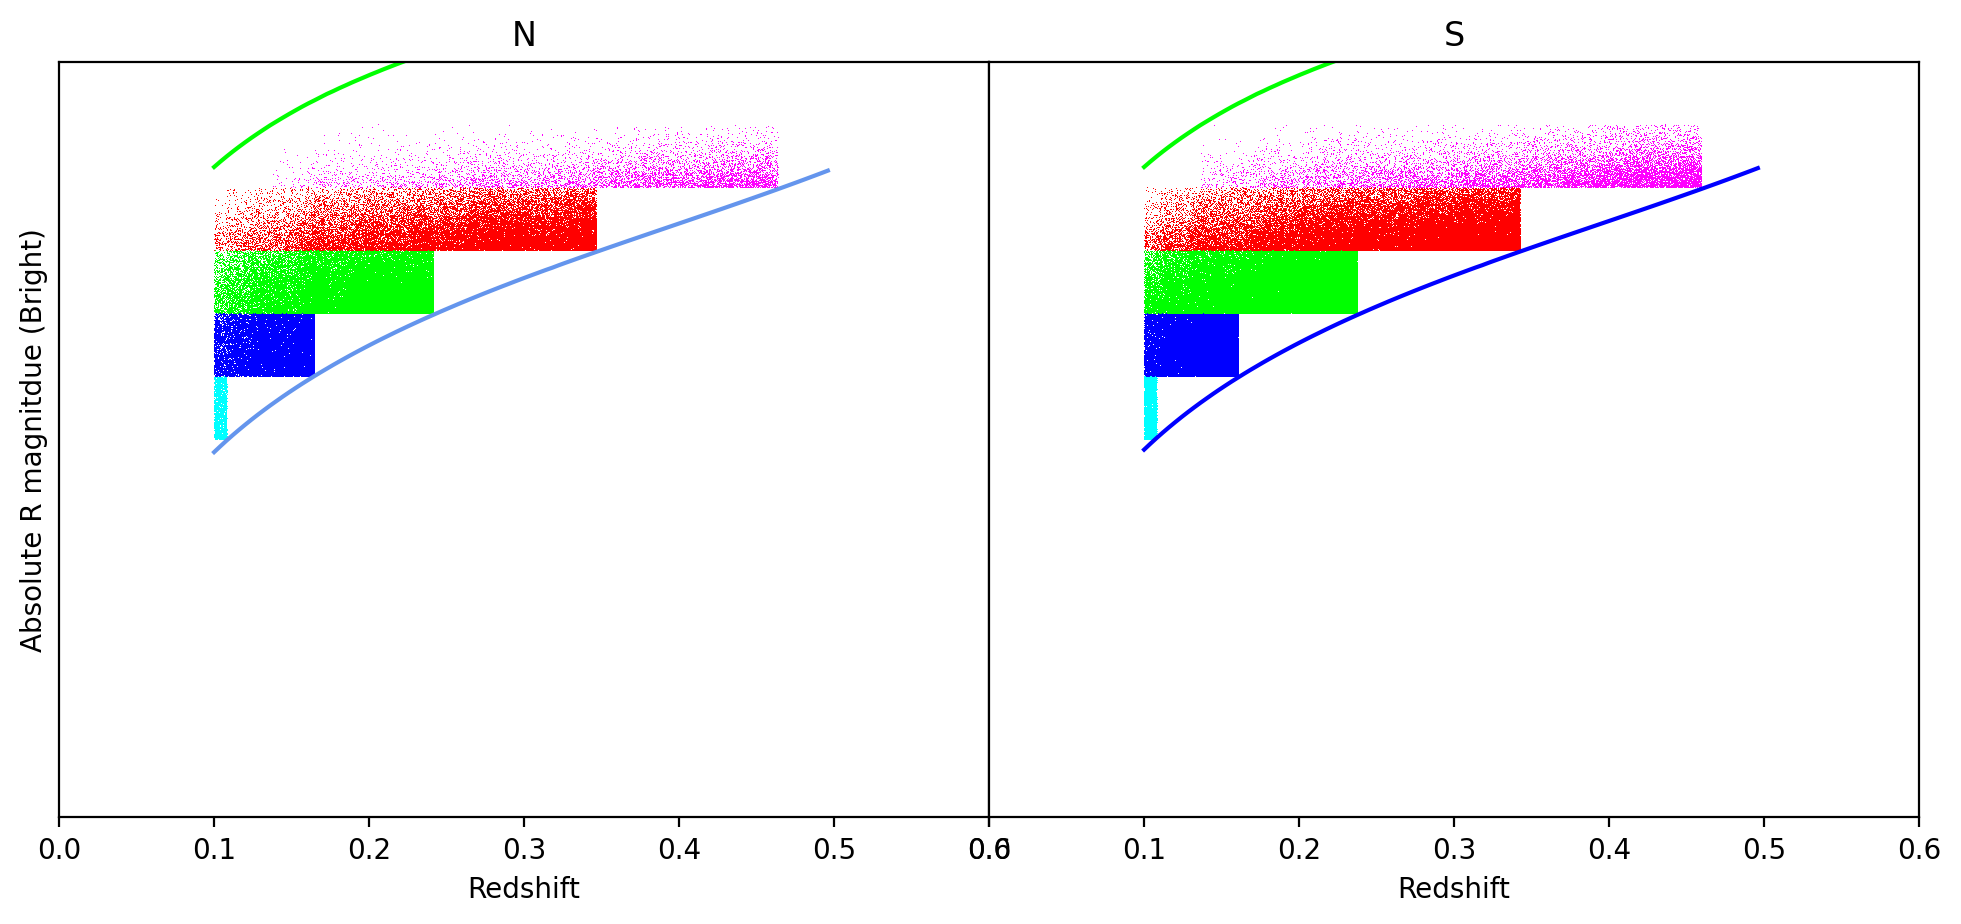

In [22]:
plt.figure(figsize=(12,5), dpi=200)

ax2 = plt.subplot(121)
plt.title('N')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-17,-18, N), redshift_lim_from_k(-17,-18, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-17,-18, N), redshift_lim_from_k(-17,-18, N))], lw=0, marker=',', color='yellow')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-18,-19, N), redshift_lim_from_k(-18,-19, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-18,-19, N), redshift_lim_from_k(-18,-19, N))], lw=0, marker=',', color='aqua')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-19,-20, N), redshift_lim_from_k(-19,-20, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-19,-20, N), redshift_lim_from_k(-19,-20, N))], lw=0, marker=',', color='blue')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-20,-21, N), redshift_lim_from_k(-20,-21, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-20,-21, N), redshift_lim_from_k(-20,-21, N))], lw=0, marker=',', color='lime')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-21,-22, N), redshift_lim_from_k(-21,-22, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-21,-22, N), redshift_lim_from_k(-21,-22, N))], lw=0, marker=',', color='red')
ax2.plot(N['Z'][np.intersect1d(absmag_lim(-22,-23, N), redshift_lim_from_k(-22,-23, N))], -N['ABSMAG_RP1'][np.intersect1d(absmag_lim(-22,-23, N), redshift_lim_from_k(-22,-23, N))], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range_bright, -M_range, color='tab:blue', lw=1)
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitdue (Bright)')

ax3 = plt.subplot(122)
plt.title('S')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-17,-18, S), redshift_lim_from_k(-17,-18, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-17,-18, S), redshift_lim_from_k(-17,-18, S))], lw=0, marker=',', color='yellow')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-18,-19, S), redshift_lim_from_k(-18,-19, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-18,-19, S), redshift_lim_from_k(-18,-19, S))], lw=0, marker=',', color='aqua')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-19,-20, S), redshift_lim_from_k(-19,-20, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-19,-20, S), redshift_lim_from_k(-19,-20, S))], lw=0, marker=',', color='blue')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-20,-21, S), redshift_lim_from_k(-20,-21, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-20,-21, S), redshift_lim_from_k(-20,-21, S))], lw=0, marker=',', color='lime')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-21,-22, S), redshift_lim_from_k(-21,-22, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-21,-22, S), redshift_lim_from_k(-21,-22, S))], lw=0, marker=',', color='red')
ax3.plot(S['Z'][np.intersect1d(absmag_lim(-22,-23, S), redshift_lim_from_k(-22,-23, S))], -S['ABSMAG_RP1'][np.intersect1d(absmag_lim(-22,-23, S), redshift_lim_from_k(-22,-23, S))], lw=0, marker=',', color='magenta')
#ax3.plot(zmax_range_bright, -M_range, color='tab:blue', lw=1)S
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8-9/main_mag_v_redshift_bright_NS.png')


Luminosity function

In [24]:
def phi(M, phi_star=8.32*10**(-3), M_star=-20.3, alpha=-0.23): #luminosity function
    return np.log(10)*phi_star*10**(0.4*(alpha+1)*(-M+M_star))*np.exp(-10**(0.4*(-M+M_star)))/2.5

In [25]:
N0 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_N_0_clustering.ran.fits')
S0 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_S_0_clustering.ran.fits')

print(np.shape(N0)[0] + np.shape(S0)[0])
sky_area = 4*np.pi*np.rad2deg(1)**2
print(sky_area)
survey_area = 434393 / 2500 #randoms / deg^2
print(survey_area) # in deg^2
fsky = survey_area/sky_area
print(fsky)

A = 705.5096+1160.9628
fsky_hdr = A/sky_area
print(fsky_hdr)
#these are different - different random number density? use fsky_hdr

434393
41252.96124941928
173.7572
0.004211993387564293
0.04524456774666751


In [26]:
zmax_clipped = np.clip(data['ZMAX'], a_min=None, a_max=0.3)
data['VMAX'] = fsky_hdr*cosmo.comoving_volume(zmax_clipped)

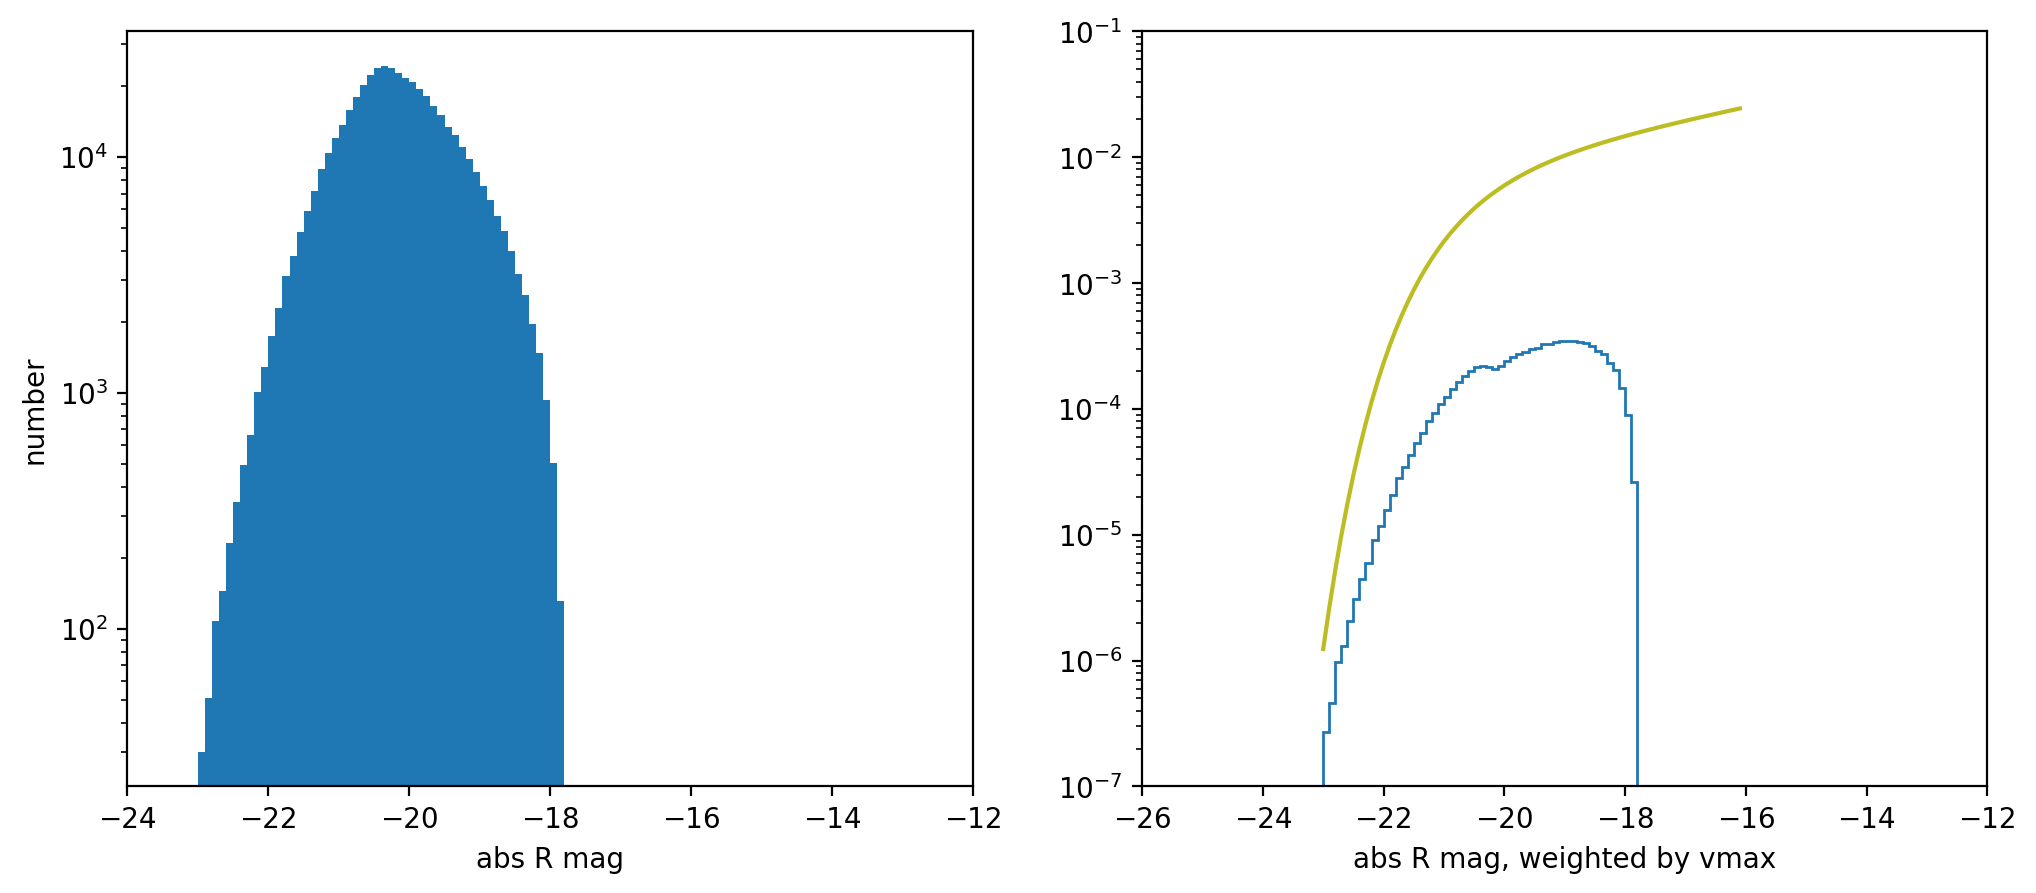

In [33]:
M_range = np.arange(-23,-16,0.1)
redshift_cut = np.where(data['Z'] <= 0.3)[0]

plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number (da02)')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range, weights=1/data['VMAX'][redshift_cut], histtype='step')
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive')
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
plt.savefig('../figures/week8-9/da02_LF.png')

compare to sv3

In [59]:
N_sv3 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_N_clustering.dat.fits')
S_sv3 = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_S_clustering.dat.fits')

In [60]:
data_sv3 = Table(np.hstack((N_sv3,S_sv3)))

In [86]:
z1 = find_nearest(data_sv3['Z'], 0.1)
z2 = find_nearest(data_sv3['Z'], 0.5)
e_slope_sv3 = (data_sv3['EQ_ALL_0P1'][z2] - data_sv3['EQ_ALL_0P1'][z1])/(data_sv3['Z'][z2] - data_sv3['Z'][z1])
print(data_sv3['Z'][z2], data_sv3['EQ_ALL_0P1'][z2])
print(data_sv3['Z'][z1], data_sv3['EQ_ALL_0P1'][z1])
print(e_slope_sv3)

e_intercept_sv3 = data_sv3['EQ_ALL_0P1'][z2] - e_slope_sv3*data_sv3['Z'][z2]
print(e_intercept_sv3)
#y = mx+c
z_range = np.linspace(0.01,0.6,80)  
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z_sv3 = e_slope_sv3*z_range[0:-1] + e_intercept_sv3 #this is correct

0.5000411802639463 -0.48503994485602786
0.10000013207827435 -0.09700012811592612
-0.9699999999999999
-5.551115123125783e-17


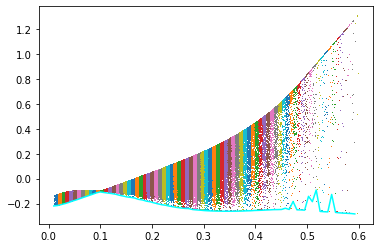

In [87]:
plt.figure()
k_min_sv3 = find_k(z_range, 'min', data_sv3)
plt.plot(z_range[0:-1], k_min_sv3, color='aqua')
plt.show()
faintlim_range_S_min_sv3 = 19.5  - 5*np.log10(dl_range) - 25 - k_min_sv3 - e_z_sv3 #this is correct

In [58]:
A_sv3 = 86.2884+87.204
sky_area = 4*np.pi*np.rad2deg(1)**2
fsky_hdr_sv3 = A_sv3/sky_area
print(fsky_hdr_sv3)

0.004205574454426402


In [88]:
data_sv3['ZMAX'] = find_zmax(data_sv3['ABSMAG_R'],faintlim_range_S_min_sv3)
zmax_clipped_sv3 = np.clip(data_sv3['ZMAX'], a_min=None, a_max=0.3)
data_sv3['VMAX'] = fsky_hdr_sv3*cosmo.comoving_volume(zmax_clipped_sv3)
redshift_cut_sv3 = np.where(data_sv3['Z'] <= 0.3)[0]
print(data_sv3['ZMAX'])

        ZMAX       
-------------------
0.09962025316455696
 0.4730379746835443
 0.2489873417721519
0.34607594936708863
0.32367088607594935
0.09962025316455696
0.27139240506329115
0.34607594936708863
0.38341772151898734
 0.5925316455696202
                ...
 0.3983544303797468
0.09962025316455696
 0.5925316455696202
 0.3535443037974684
 0.4879746835443038
 0.3012658227848101
0.34607594936708863
0.18924050632911393
 0.5178481012658228
 0.5925316455696202
0.34607594936708863
Length = 143853 rows


(-26.0, -12.0)

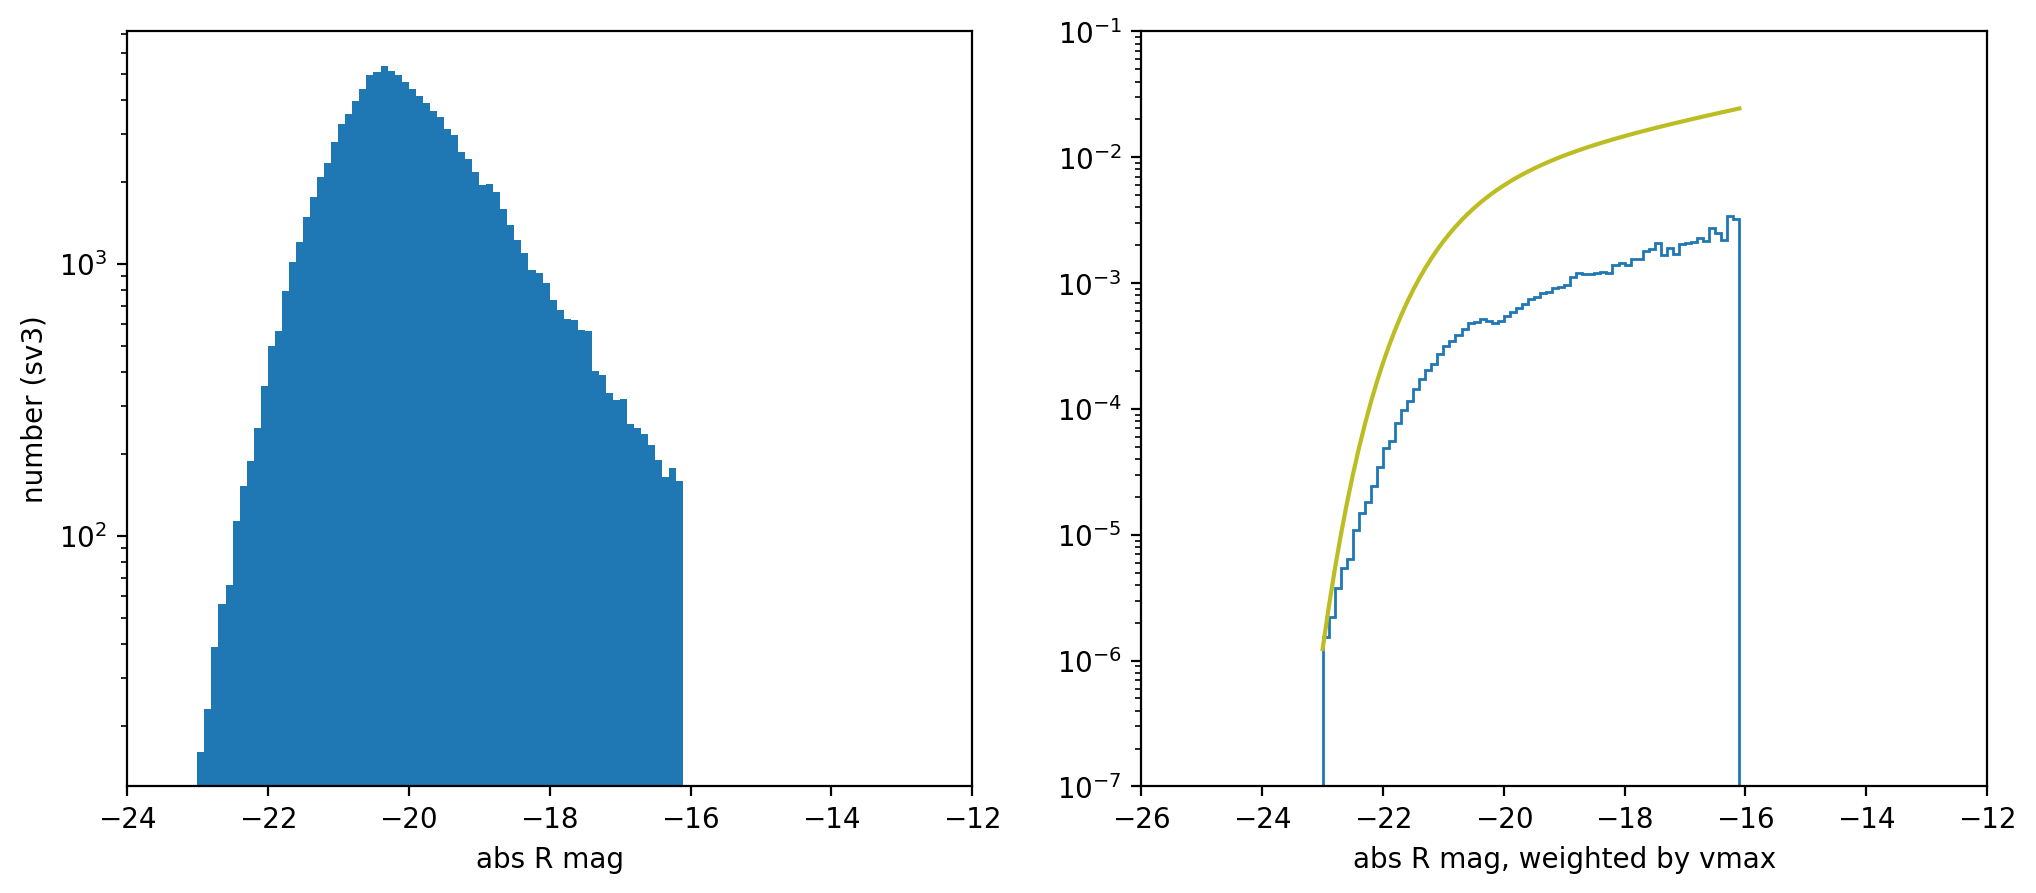

In [90]:
M_range = np.arange(-23,-16,0.1)
plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number (sv3)')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range, weights=1/data_sv3['VMAX'][redshift_cut_sv3], histtype='step')
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive', label='McNaught-Roberts+2014')
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)

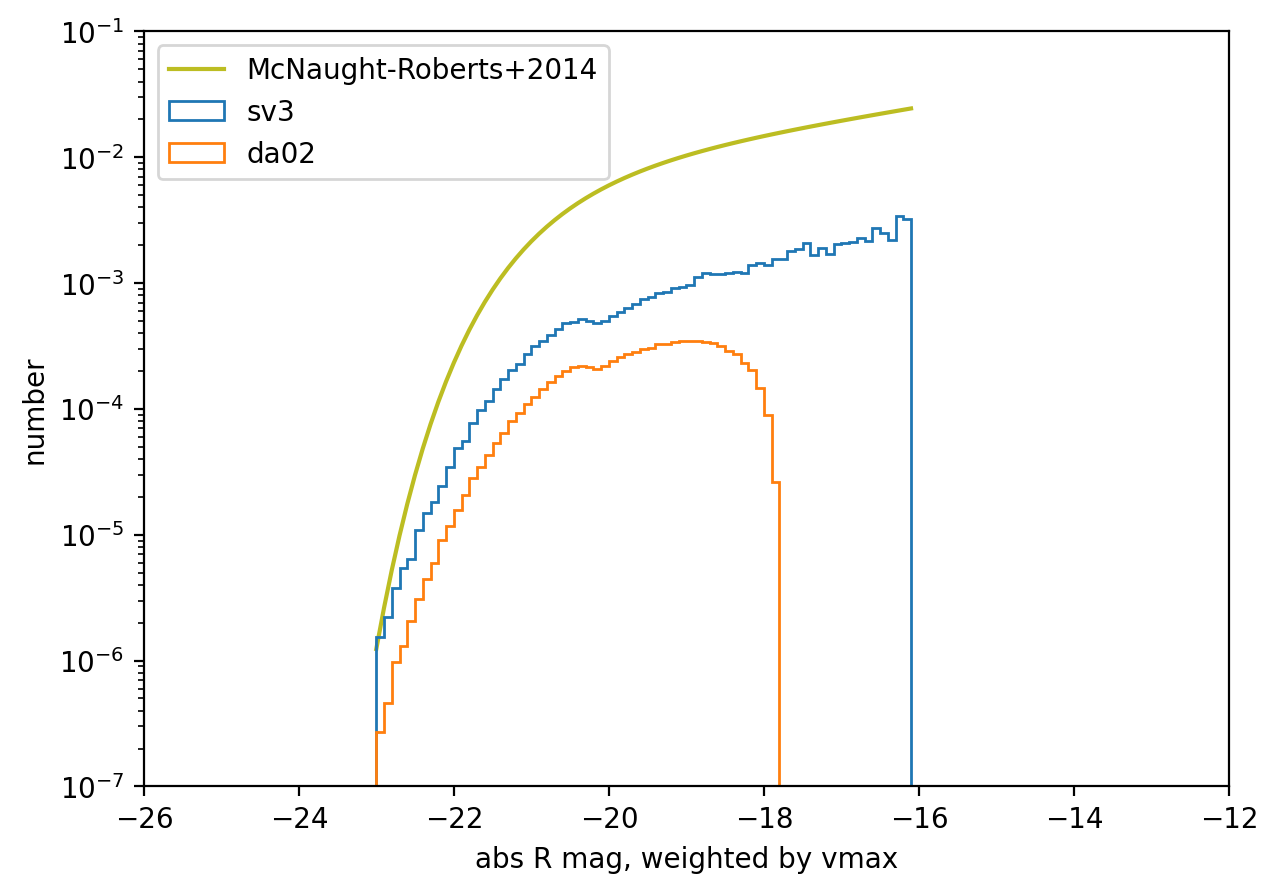

In [94]:
fig, ax = plt.subplots(figsize=(7,5),dpi=200)
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
ax.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.70, alpha=-1.25), color='tab:olive', label='McNaught-Roberts+2014')
ax.hist(data_sv3['ABSMAG_R'][redshift_cut_sv3], bins=M_range, weights=1/data_sv3['VMAX'][redshift_cut_sv3], histtype='step', label='sv3')
ax.hist(data['ABSMAG_RP1'][redshift_cut], bins=M_range, weights=1/data['VMAX'][redshift_cut], histtype='step', label='da02')
ax.set_yscale('log')
plt.legend()
plt.xlabel('abs R mag, weighted by vmax')
plt.ylabel('number')
plt.savefig('../figures/week8-9/LF_comparison.png')